# Running simulations  

In this tutorial, we are going to cover the following topics:

* How to merge compartments into compartmental neuron models
* How to make Dendrify and Brian interact with each other
* How to run simulations of Dendrify models in Brian

`Disclaimer: Below, we present a generic "toy" model developed solely for educational purposes. However, please note that its parameters and behavior have not been validated using real data. If you intend to utilize Dendrify in a project, we strongly advise against using this model as it is, unless you first calibrate its parameters to align with your specific requirements.`

## Imports

In [1]:
import brian2 as b
import matplotlib.pyplot as plt
from brian2.units import *
from dendrify import Soma, Dendrite, NeuronModel

b.prefs.codegen.target = 'numpy' # faster for basic models and short simulations

In [2]:
# Plot settings
blue = '#005c94ff'
green = '#338000ff'
orange = '#ff6600ff'
notred = '#aa0044ff'
params = {
          "legend.fontsize": 10,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 10,
          "axes.titlesize": 11,
          "axes.spines.right": False,
          "axes.spines.top": False,
          "xtick.labelsize": 10,
          "ytick.labelsize": 10,
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.color': "#d3d3d3",
          'figure.dpi': 150,
          'axes.prop_cycle': b.cycler(color=[blue, green, orange, notred])
          }

plt.rcParams.update(params)

## Create a compartmental model

Lets try to recreate the following basic 4-compartment model:

<center><img src="https://github.com/Poirazi-Lab/dendrify/blob/main/paper_figures/graphics/2.png?raw=true" alt="model" width="25%"></center>




According to the previous tutorial the code should look somethink like this:

In [3]:
# create soma
soma = Soma('soma', model='leakyIF', length=25*um, diameter=25*um,
            cm=1*uF/(cm**2), gl=40*uS/(cm**2),
            v_rest=-65*mV)

# create trunk
trunk = Dendrite('trunk', length=100*um, diameter=2.5*um,
                 cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                 v_rest=-65*mV)

# create proximal dendrite
prox = Dendrite('prox', length=100*um, diameter=1*um,
                cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                v_rest=-65*mV)
prox.synapse('AMPA', tag='pathY', g=1*nS,  t_decay=2*ms)
prox.synapse('NMDA', tag='pathY', g=1*nS,  t_decay=60*ms)

# create distal dendrite
dist = Dendrite('dist', length=100*um, diameter=0.5*um,
                cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                v_rest=-65*mV)
dist.synapse('AMPA', tag='pathX', g=1*nS,  t_decay=2*ms)
dist.synapse('NMDA', tag='pathX', g=1*nS,  t_decay=60*ms)

soma.connect(trunk, g=15*nS)
trunk.connect(prox, g=6*nS)
prox.connect(dist, g=2*nS)

HOWEVER: There is a far better way for creating a compartmental model!!

In [4]:
# create compartments
soma = Soma('soma', model='leakyIF', length=25*um, diameter=25*um)
trunk = Dendrite('trunk', length=100*um, diameter=2.5*um)
prox = Dendrite('prox', length=100*um, diameter=1*um)
dist = Dendrite('dist', length=100*um, diameter=0.5*um)

# add AMPA/NMDA synapses
prox.synapse('AMPA', tag='pathY', g=1*nS,  t_decay=2*ms)
prox.synapse('NMDA', tag='pathY', g=1*nS,  t_decay=60*ms)
dist.synapse('AMPA', tag='pathX', g=1*nS,  t_decay=2*ms)
dist.synapse('NMDA', tag='pathX', g=1*nS,  t_decay=60*ms)

# merge compartments into a  neuron model and set its basic properties
graph = [(soma, trunk, 15*nS), (trunk, prox, 6*nS), (prox, dist, 2*nS)]
model = NeuronModel(graph, cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                    v_rest=-65*mV, scale_factor=2.8, spine_factor=1.5)

The NeuronModel class, not only allows to set model parameters, but also unlocks many cool functions that we are going to explore now.

In [5]:
print(model)


OBJECT
------
<class 'dendrify.neuronmodel.NeuronModel'>


EQUATIONS
---------
dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma) / C_soma  :volt
I_soma = I_ext_soma + I_trunk_soma   :amp
I_ext_soma  :amp
I_trunk_soma = (V_trunk-V_soma) * g_trunk_soma  :amp

dV_trunk/dt = (gL_trunk * (EL_trunk-V_trunk) + I_trunk) / C_trunk  :volt
I_trunk = I_ext_trunk + I_prox_trunk  + I_soma_trunk   :amp
I_ext_trunk  :amp
I_soma_trunk = (V_soma-V_trunk) * g_soma_trunk  :amp
I_prox_trunk = (V_prox-V_trunk) * g_prox_trunk  :amp

dV_prox/dt = (gL_prox * (EL_prox-V_prox) + I_prox) / C_prox  :volt
I_prox = I_ext_prox + I_dist_prox  + I_trunk_prox  + I_NMDA_pathY_prox + I_AMPA_pathY_prox  :amp
I_ext_prox  :amp
I_AMPA_pathY_prox = g_AMPA_pathY_prox * (E_AMPA-V_prox) * s_AMPA_pathY_prox * w_AMPA_pathY_prox  :amp
ds_AMPA_pathY_prox/dt = -s_AMPA_pathY_prox / t_AMPA_decay_pathY_prox  :1
I_NMDA_pathY_prox = g_NMDA_pathY_prox * (E_NMDA-V_prox) * s_NMDA_pathY_prox / (1 + Mg_con * exp(-Alpha_NMDA*(V_prox/mV+Gamma_N

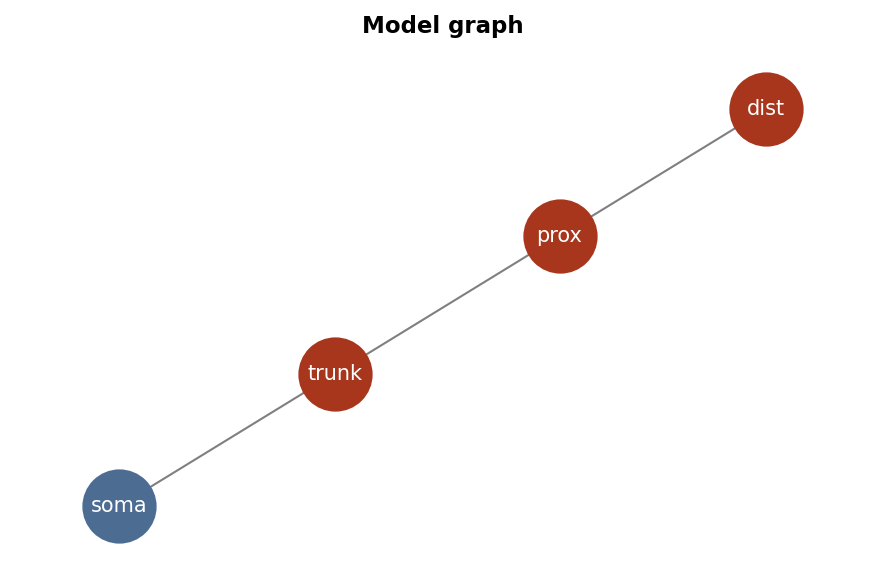

In [6]:
model.as_graph()

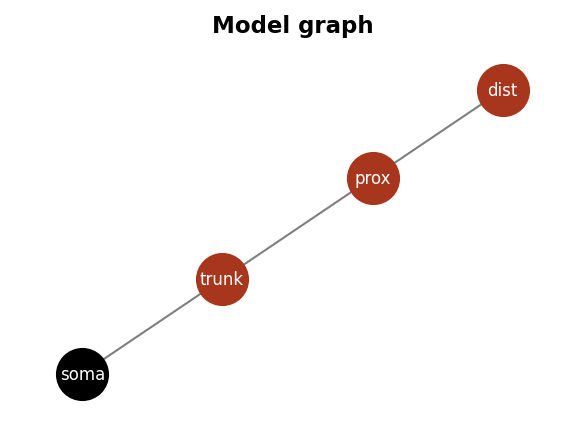

In [7]:
model.as_graph(figsize=[4,3], scale_nodes=0.5, fontsize=8, color_soma='black')

## Dendrify meets Brian

In [8]:
neuron, ap_reset = model.make_neurongroup(1, method='euler', threshold='V_soma > -40*mV',
                                reset='V_soma = 40*mV',
                                second_reset= 'V_soma=-55*mV',
                                spike_width = 0.5*ms,
                                refractory=4*ms)

In [9]:
# Set a monitor to record the voltages of all compartments
voltages = ['V_soma', 'V_trunk', 'V_prox', 'V_dist']
M = b.StateMonitor(neuron, voltages, record=True)

## Run simulation and plot results

In [10]:
net = b.Network(neuron, ap_reset, M)  # organize everythink into a network
net.run(10*ms)  # no input
neuron.I_ext_soma = 200*pA
net.run(100*ms)  # 200 pA injected at the soma for 100 ms
neuron.I_ext_soma = 0*pA
net.run(60*ms) # run another 60 ms without any input

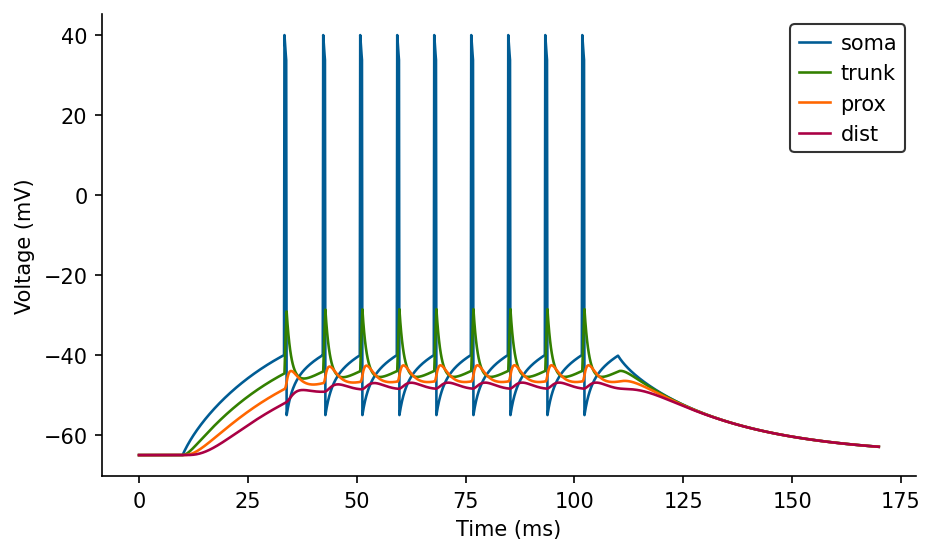

In [11]:
# Plot voltages
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(M.t/ms, M.V_soma[0]/mV, label='soma')
ax.plot(M.t/ms, M.V_trunk[0]/mV, label='trunk')
ax.plot(M.t/ms, M.V_prox[0]/mV, label='prox')
ax.plot(M.t/ms, M.V_dist[0]/mV, label='dist')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.legend(loc='best');

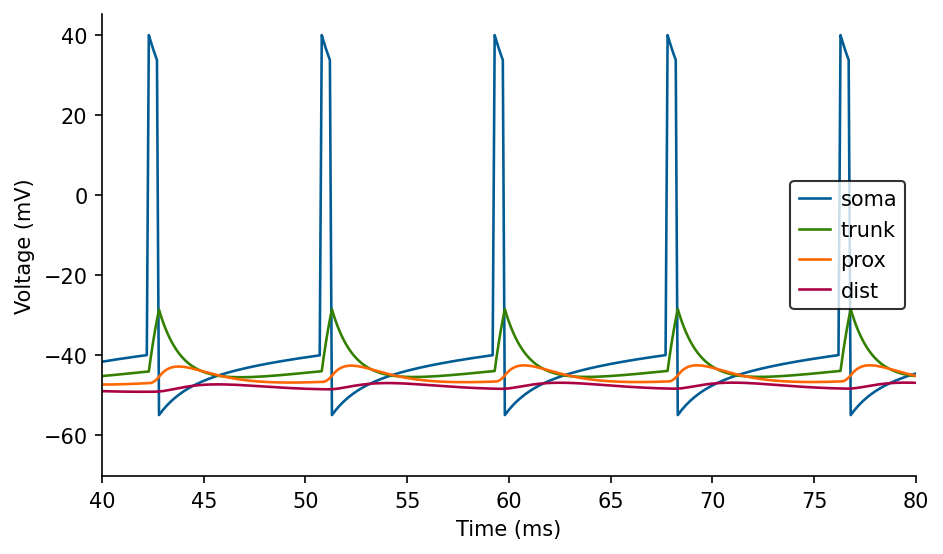

In [12]:
# Zoom in
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(M.t/ms, M.V_soma[0]/mV, label='soma')
ax.plot(M.t/ms, M.V_trunk[0]/mV, label='trunk')
ax.plot(M.t/ms, M.V_prox[0]/mV, label='prox')
ax.plot(M.t/ms, M.V_dist[0]/mV, label='dist')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_xlim(left=40, right=80)
ax.legend(loc='best');

NOTE: The dendritic voltage fluctuations that follow somatic APs are due to the electrical coupling of these compartments. They are not backpropagating dSpikes (not included yet in the model)

## A network with random input

In [13]:
b.start_scope() # clear previous run

# First create 2 input groups
inputX = b.PoissonGroup(50, 10*Hz) # 50 neurons firing at 10 Hz
inputY = b.PoissonGroup(50, 10*Hz) # 50 neurons firing at 10 Hz

# And a NEWronGroup (I am so funny)
group, ap_reset = model.make_neurongroup(100, method='euler', threshold='V_soma > -40*mV',
                                reset='V_soma = 40*mV',
                                second_reset= 'V_soma=-55*mV',
                                spike_width = 0.5*ms,
                                refractory=4*ms)

In [14]:
# Let's remember how the equations look like:
print(dist.equations)

dV_dist/dt = (gL_dist * (EL_dist-V_dist) + I_dist) / C_dist  :volt
I_dist = I_ext_dist + I_NMDA_pathX_dist + I_AMPA_pathX_dist  :amp
I_ext_dist  :amp
I_AMPA_pathX_dist = g_AMPA_pathX_dist * (E_AMPA-V_dist) * s_AMPA_pathX_dist * w_AMPA_pathX_dist  :amp
ds_AMPA_pathX_dist/dt = -s_AMPA_pathX_dist / t_AMPA_decay_pathX_dist  :1
I_NMDA_pathX_dist = g_NMDA_pathX_dist * (E_NMDA-V_dist) * s_NMDA_pathX_dist / (1 + Mg_con * exp(-Alpha_NMDA*(V_dist/mV+Gamma_NMDA)) / Beta_NMDA) * w_NMDA_pathX_dist  :amp
ds_NMDA_pathX_dist/dt = -s_NMDA_pathX_dist/t_NMDA_decay_pathX_dist  :1


In [15]:
# Define what happens when a presynaptic spike arrives at the synapse
synX = b.Synapses(inputX, group,
                  on_pre='s_AMPA_pathX_dist += 1; s_NMDA_pathX_dist += 1')
synY = b.Synapses(inputY, group,
                  on_pre='s_AMPA_pathY_prox += 1; s_NMDA_pathY_prox += 1')

# This is the actual connection part
synX.connect(p=0.5) # 50% of the inputs X connect to the group
synY.connect(p=0.5) # 50% of the inputs Y connect to the group

In [16]:
# Set spike and voltage monitors
S = b.SpikeMonitor(group)

voltages = ['V_soma', 'V_trunk', 'V_prox', 'V_dist']
M = b.StateMonitor(group, voltages, record=True)

In [17]:
# Run simulation
net = b.Network(group, ap_reset, synX, synY, S)
b.run(1000*ms)

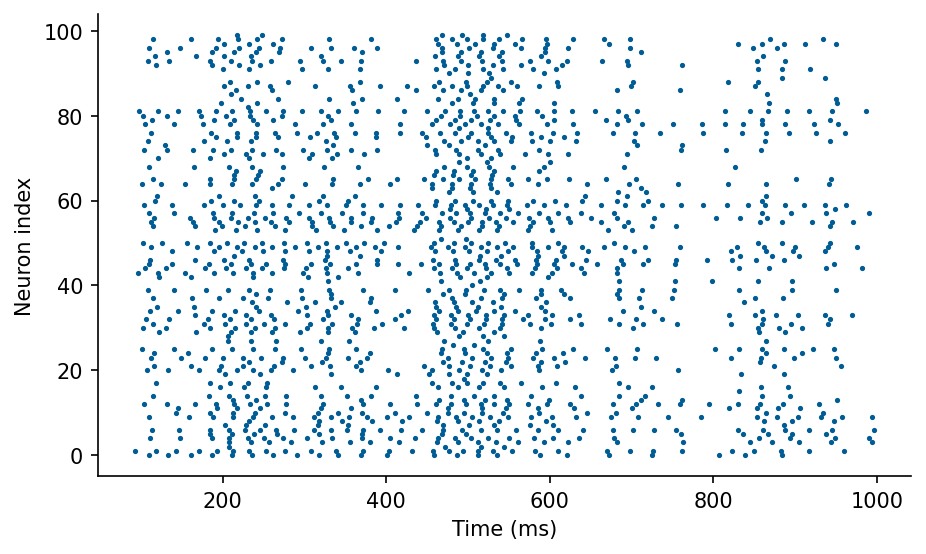

In [18]:
# Plot spiketimes
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(S.t/ms, S.i, '.')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron index');

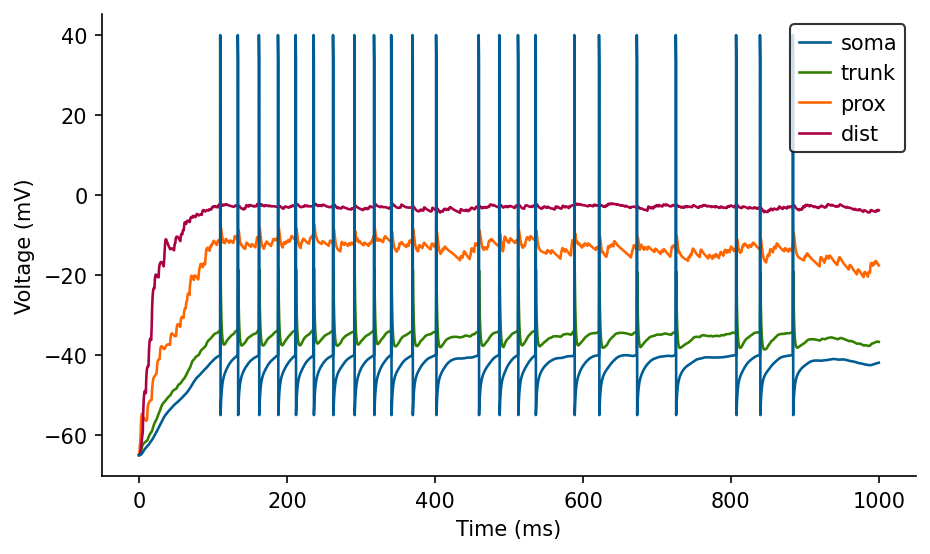

In [19]:
# Plot voltages
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(M.t/ms, M.V_soma[0]/mV, label='soma', zorder=3)
ax.plot(M.t/ms, M.V_trunk[0]/mV, label='trunk')
ax.plot(M.t/ms, M.V_prox[0]/mV, label='prox')
ax.plot(M.t/ms, M.V_dist[0]/mV, label='dist')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.legend(loc='best');

## Playing with dSpikes

In [20]:
b.start_scope() # clear previous run

# add channels to compartments
dist.dspikes('Na', g_rise=3.7*nS, g_fall=2.4*nS)
prox.dspikes('Na', g_rise=9*nS, g_fall=5.7*nS)
trunk.dspikes('Na', g_rise=22*nS, g_fall=14*nS)


model = NeuronModel(graph, cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                    v_rest=-65*mV, r_axial=150*ohm*cm,
                    scale_factor=2.8, spine_factor=1.5)

model.config_dspikes('Na', threshold=-35*mV,
                     duration_rise=1.2*ms, duration_fall=2.4*ms,
                     offset_fall=0.2*ms, refractory=5*ms,
                     reversal_rise='E_Na', reversal_fall='E_K')

In [21]:
print(model)


OBJECT
------
<class 'dendrify.neuronmodel.NeuronModel'>


EQUATIONS
---------
dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma) / C_soma  :volt
I_soma = I_ext_soma + I_trunk_soma   :amp
I_ext_soma  :amp
I_trunk_soma = (V_trunk-V_soma) * g_trunk_soma  :amp

dV_trunk/dt = (gL_trunk * (EL_trunk-V_trunk) + I_trunk) / C_trunk  :volt
I_trunk = I_ext_trunk + I_prox_trunk  + I_soma_trunk  + I_rise_Na_trunk + I_fall_Na_trunk  :amp
I_ext_trunk  :amp
I_rise_Na_trunk = g_rise_Na_trunk * (E_rise_Na-V_trunk)  :amp
I_fall_Na_trunk = g_fall_Na_trunk * (E_fall_Na-V_trunk)  :amp
g_rise_Na_trunk = g_rise_max_Na_trunk * int(t_in_timesteps <= spiketime_Na_trunk + duration_rise_Na_trunk) * gate_Na_trunk :siemens
g_fall_Na_trunk = g_fall_max_Na_trunk * int(t_in_timesteps <= spiketime_Na_trunk + offset_fall_Na_trunk + duration_fall_Na_trunk) * int(t_in_timesteps >= spiketime_Na_trunk + offset_fall_Na_trunk) *  gate_Na_trunk :siemens
spiketime_Na_trunk  :1
gate_Na_trunk  :1
I_soma_trunk = (V_soma-V_trunk) *

In [22]:
# Make a new neurongroup
neuron, ap_reset = model.make_neurongroup(1, method='euler', threshold='V_soma > -40*mV',
                                reset='V_soma = 40*mV',
                                second_reset= 'V_soma=-55*mV',
                                spike_width = 0.8*ms,
                                refractory=4*ms)

vars = ['V_soma', 'V_trunk', 'V_prox', 'V_dist']
M = b.StateMonitor(neuron, vars, record=True)

net = b.Network(neuron, ap_reset, M)
net.run(10*ms)
neuron.I_ext_soma = 150*pA
net.run(100*ms)
neuron.I_ext_soma = 0*pA
net.run(60*ms)

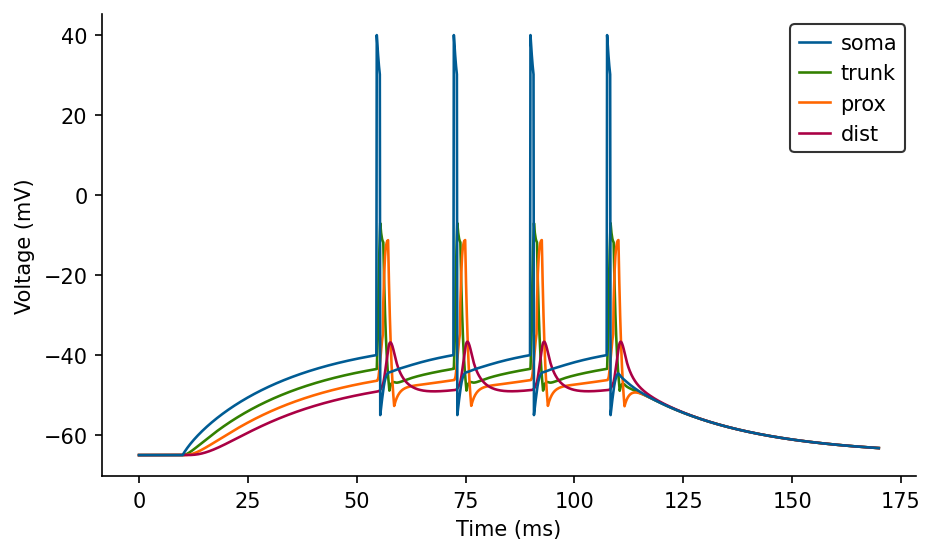

In [23]:
# @title Plot voltages
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(M.t/ms, M.V_soma[0]/mV, label='soma', zorder=3)
ax.plot(M.t/ms, M.V_trunk[0]/mV, label='trunk')
ax.plot(M.t/ms, M.V_prox[0]/mV, label='prox')
ax.plot(M.t/ms, M.V_dist[0]/mV, label='dist')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.legend(loc='best');

Now these are some actual backpropagating dendritic spikes with sodium-like characteristics.

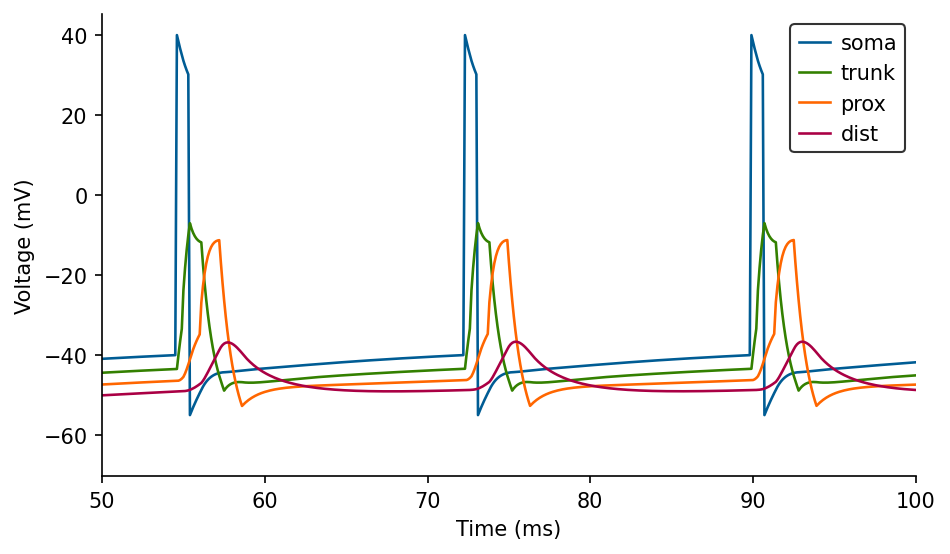

In [24]:
# Zoom in
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(M.t/ms, M.V_soma[0]/mV, label='soma')
ax.plot(M.t/ms, M.V_trunk[0]/mV, label='trunk')
ax.plot(M.t/ms, M.V_prox[0]/mV, label='prox')
ax.plot(M.t/ms, M.V_dist[0]/mV, label='dist')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_xlim(left=50, right=100)
ax.legend(loc='best');

## Adding some noise

In [25]:
b.start_scope() # clear previous run

# add noise
a = 2
soma.noise(mean=a*25*pA, sigma=25*pA, tau=1*ms)
trunk.noise(mean=a*20*pA, sigma=20*pA, tau=1*ms)
prox.noise(mean=a*15*pA, sigma=15*pA, tau=1*ms)
dist.noise(mean=a*6*pA, sigma=10*pA, tau=1*ms)


# merge compartments into a  neuron model and set its basic properties
edges = [(soma, trunk, 15*nS), (trunk, prox, 8*nS), (prox, dist, 3*nS)]
model = NeuronModel(edges, cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                    v_rest=-65*mV, r_axial=150*ohm*cm,
                    scale_factor=2.8, spine_factor=1.5)

model.config_dspikes('Na', threshold=-35*mV,
                     duration_rise=1.2*ms, duration_fall=2.4*ms,
                     offset_fall=0.2*ms, refractory=5*ms,
                     reversal_rise='E_Na', reversal_fall='E_K')

# make a neuron group
neuron, ap_reset = model.make_neurongroup(1, method='euler', threshold='V_soma > -40*mV',
                                reset='V_soma = 40*mV',
                                second_reset= 'V_soma=-55*mV',
                                spike_width = 0.8*ms,
                                refractory=4*ms)

# record voltages
vars = ['V_soma', 'V_trunk', 'V_prox', 'V_dist']
M = b.StateMonitor(neuron, vars, record=True)

In [26]:
print(model)


OBJECT
------
<class 'dendrify.neuronmodel.NeuronModel'>


EQUATIONS
---------
dV_soma/dt = (gL_soma * (EL_soma-V_soma) + I_soma) / C_soma  :volt
I_soma = I_ext_soma + I_trunk_soma  + I_noise_soma  :amp
I_ext_soma  :amp
dI_noise_soma/dt = (mean_noise_soma-I_noise_soma) / tau_noise_soma + sigma_noise_soma * (sqrt(2/(tau_noise_soma*dt)) * randn()) :amp
I_trunk_soma = (V_trunk-V_soma) * g_trunk_soma  :amp

dV_trunk/dt = (gL_trunk * (EL_trunk-V_trunk) + I_trunk) / C_trunk  :volt
I_trunk = I_ext_trunk + I_prox_trunk  + I_soma_trunk  + I_noise_trunk + I_rise_Na_trunk + I_fall_Na_trunk  :amp
I_ext_trunk  :amp
I_rise_Na_trunk = g_rise_Na_trunk * (E_rise_Na-V_trunk)  :amp
I_fall_Na_trunk = g_fall_Na_trunk * (E_fall_Na-V_trunk)  :amp
g_rise_Na_trunk = g_rise_max_Na_trunk * int(t_in_timesteps <= spiketime_Na_trunk + duration_rise_Na_trunk) * gate_Na_trunk :siemens
g_fall_Na_trunk = g_fall_max_Na_trunk * int(t_in_timesteps <= spiketime_Na_trunk + offset_fall_Na_trunk + duration_fall_Na_trunk) * i

In [27]:
# run simulation
net = b.Network(neuron, ap_reset, M)
net.run(500*ms)

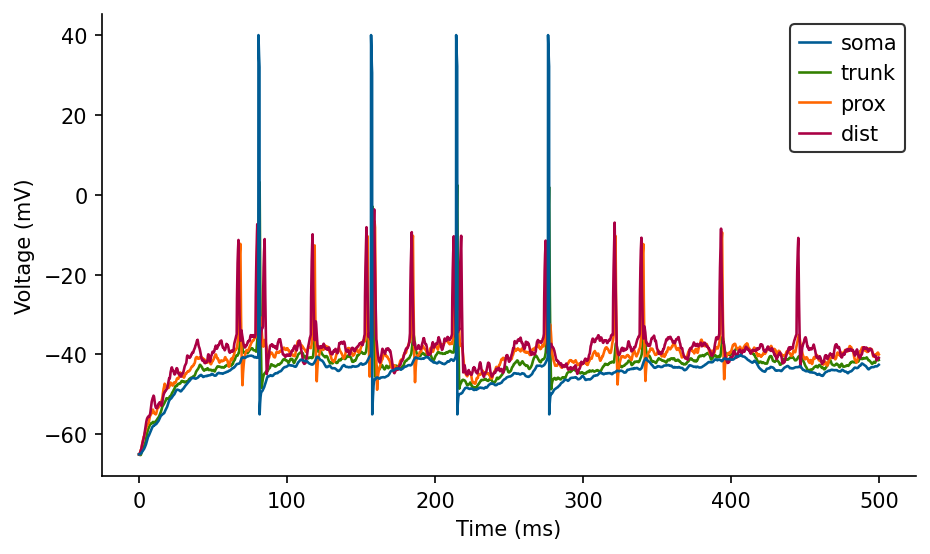

In [28]:
# @title Plot voltages
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(M.t/ms, M.V_soma[0]/mV, label='soma', zorder=3)
ax.plot(M.t/ms, M.V_trunk[0]/mV, label='trunk')
ax.plot(M.t/ms, M.V_prox[0]/mV, label='prox')
ax.plot(M.t/ms, M.V_dist[0]/mV, label='dist')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.legend(loc='best');

## Point neurons

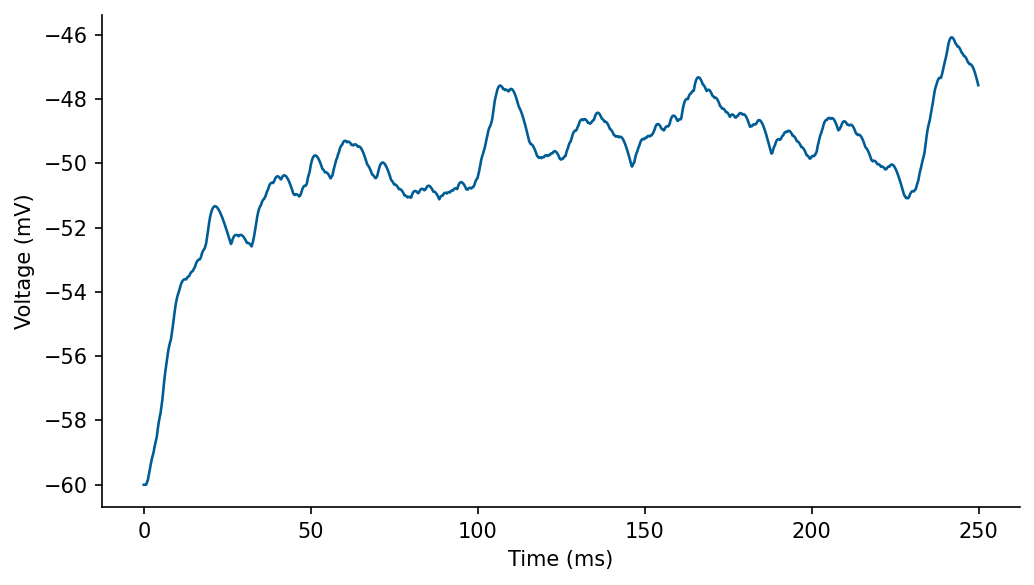

In [29]:
from dendrify import PointNeuronModel

b.start_scope()

# create a point-neuron model and add some Poisson input
point_model = PointNeuronModel('p', model='leakyIF', v_rest=-60*mV,
                               cm_abs=200*pF, gl_abs=10*nS)
point_model.synapse('AMPA', tag='x', g=1*nS, t_decay=2*ms)
point_neuron = point_model.make_neurongroup(1, method='euler')  # no spiking

Input = b.PoissonGroup(10, rates=100*Hz)
S = b.Synapses(Input, point_neuron, on_pre='s_AMPA_x_p += 1')
S.connect(p=1)

# monitor
M2 = b.StateMonitor(point_neuron, 'V_p', record=True)

# simulation
b.run(250*ms)

# plot
fig, ax = plt.subplots(1, 1, figsize=[7, 4])
ax.plot(M2.t/ms, M2.V_p[0]/mV)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
fig.tight_layout();